In [1]:
from sklearn import cluster
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
import pickle
from datetime import datetime
from sklearn.cluster import KMeans

In [2]:
with open ('polemic_comments.pkl', 'rb') as fp:
    polemic_comments = pickle.load(fp)

In [3]:
"достать все комментарии в каждом кластере"
only_comments_by_cluster = {}
for clstr in polemic_comments:
    clstr_comments = []
    cntr_articles = 0
    for article in clstr[1]:
        cntr_articles += 1
        comments_arr = article[2]
        #print(len(comments_arr))
        if len(comments_arr) != 0:
            #print(comments_arr)
            for inner_tuple in comments_arr:
                #print(inner_tuple)
                for comment_text in inner_tuple[1]:
                    clstr_comments.append(comment_text)
    cntr_comments = len(clstr_comments)
    print(clstr[0], cntr_articles, cntr_comments, cntr_comments/cntr_articles)
    only_comments_by_cluster[clstr[0]] = clstr_comments

6 18 74 4.111111111111111
7 28 87 3.107142857142857
12 13 30 2.3076923076923075
16 7 31 4.428571428571429
20 32 443 13.84375
21 20 248 12.4
24 8 47 5.875
30 68 1521 22.36764705882353
33 17 985 57.94117647058823
34 16 334 20.875


In [4]:
import nltk, math, codecs
from gensim.models import Doc2Vec
import re
import pymorphy2
from datetime import datetime

fname = 'noStopLemma_PV-DBOW_wrd-vec_1it_2win_6mincount_alpha25-25_sz80.model'

model = Doc2Vec.load(fname)

morph = pymorphy2.MorphAnalyzer()

C:\Anaconda\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
with open('stopwords.txt', 'r', encoding='utf-8') as f:
    txt = f.read().split('\n')
stw = set(txt)

In [ ]:
def distanceToCentroid():
    all_distances = []
    for i in range(NUM_CLUSTERS):
        clustersize = 0
        for j in range(0, len(assigned_clusters)):
            if (assigned_clusters[j] == i):
                clustersize+=1
        clustersizes.append(clustersize)
        dist = 0.0
        centr = km.cluster_centers_[i]
        for j in range(0, len(assigned_clusters)):
            if (assigned_clusters[j] == i):
                dist += pow(nltk.cluster.util.cosine_distance(vectors[j], centr),2)/clustersize
        dist = math.sqrt(dist)
        all_distances.append(dist)
        #print("distance cluster: "+str(i)+" RMSE: "+str(dist)+" clustersize: "+str(clustersize))
    return all_distances

def nClosestToCentroid(cluster_id, n):
    #clustersize = len(get_titles_by_cluster(cluster_id))
    centr = km.cluster_centers_[clstr]
    distances = []
    for j in range(0, len(assigned_clusters)):
        if (assigned_clusters[j] == cluster_id):
            distances.append((used_lines[j], nltk.cluster.util.cosine_distance(vectors[j], centr)))
    distances = sorted(distances, key=lambda tup: tup[1])
    return distances[:n]


def get_titles_by_cluster(id):
    list = []
    for x in range(0, len(assigned_clusters)):
        if (assigned_clusters[x] == id):
            list.append(used_lines[x])
    return list

def get_topics(titles):
    from collections import Counter
    words = [preprocess_document(x) for x in titles]
    words = [word for sublist in words for word in sublist]
    #filtered_words = [word for word in words if word not in stw]
    count = Counter(words)
    print(count.most_common()[:5])


def cluster_to_topics(id):
    get_topics(get_titles_by_cluster(id))

inferring vectors


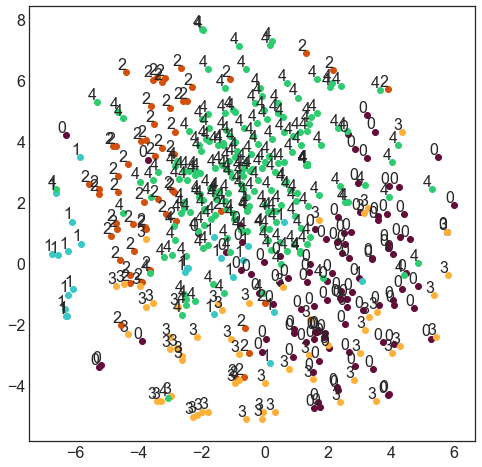

inferring vectors


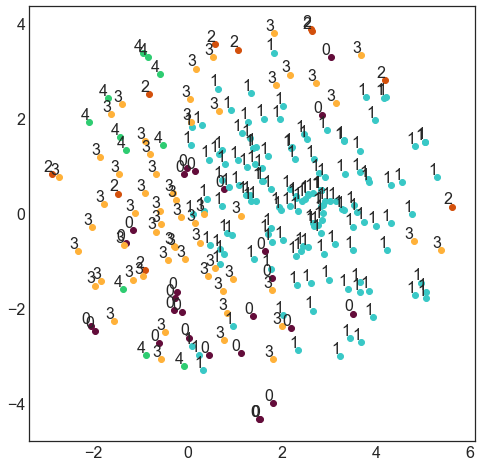

inferring vectors


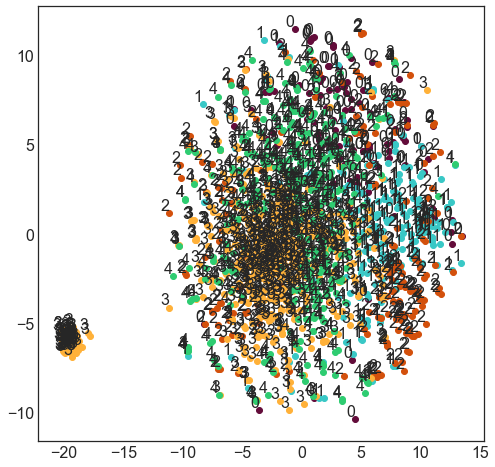

inferring vectors


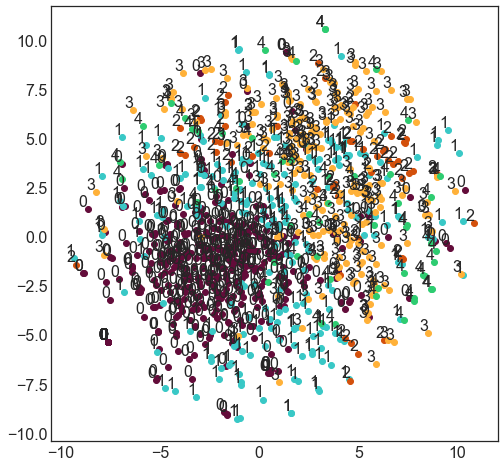

inferring vectors


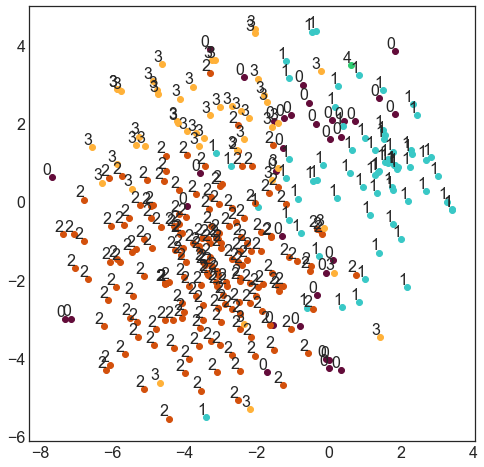

done


In [91]:
def preprocess(str):
    # remove links
    str = re.sub(r'http(s)?:\/\/\S*? ', "", str)
    return str


def preprocess_document(text):
    #text = preprocess(text)
    fixedNoStop = []
    fixed = ''.join([x if x.isalnum() or x.isspace() else " " for x in text ]).split()
    for fix in fixed:
        if fix not in stw:
            fix = morph.parse(fix)[0].normal_form
            fixedNoStop.append(fix)
    return fixedNoStop

start_time = datetime.now()

comm_clusters = []
chosen_clstrs = ['20', '21', '30', '33', '34']
NUM_CLUSTERS = 5
divider = 6
    
for polem_clstr in chosen_clstrs:
    lines = only_comments_by_cluster[polem_clstr]
    for line in range(len(lines)):
        lines[line] = lines[line].lower()

    vectors = []

    print("inferring vectors")
    duplicate_dict = {}
    used_lines = []
    for i, t in enumerate(lines):
        if t not in duplicate_dict:
            duplicate_dict[t] = True
            used_lines.append(t)
            vectors.append(model.infer_vector(preprocess_document(t)))
            
    clustersizes = []
    km = KMeans(n_clusters=NUM_CLUSTERS, init='k-means++', max_iter=100, n_init=8)
    km.fit(vectors)
    assigned_clusters = km.labels_
    
    theme_clstrs = []
    for clstr in range(NUM_CLUSTERS):
        n = round(len(get_titles_by_cluster(clstr))/divider)
        theme_clstrs.append(nClosestToCentroid(clstr, n))
    comm_clusters.append(theme_clstrs)
    "Creates a TSNE model and plots it"
    labels = []
    tokens = []

    for cluster_id in range(NUM_CLUSTERS):
        for j in range(0, len(assigned_clusters)):
            if (assigned_clusters[j] == cluster_id):
                tokens.append(vectors[j])
                labels.append(cluster_id)

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    customPalette = {0:'#630C3A', 1:'#39C8C6', 2:'#D3500C', 3:'#FFB139', 4:'#2ecc71'}

    plt.figure(figsize=(8,8)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i], c = customPalette[labels[i]])
        plt.annotate(labels[i],
                        xy=(x[i], y[i]),
                        xytext=(0,0),
                        textcoords='offset pixels',
                        ha='right',
                        va='bottom')
    plt.show()

print("done")

In [61]:
tsne_plot(NUM_CLUSTERS)

NameError: name 'matplotlib' is not defined